In [1]:
#used to allow importing of physicsnemo
import sys
sys.path.append("/global/u2/k/kfrields/climsim-kaggle-edition")

import numpy as np
from sklearn.metrics import r2_score
import torch
import os, gc
from climsim_utils.data_utils import *
from tqdm import tqdm
from matplotlib import cm
import torch
from physicsnemo.models.diffusion.preconditioning import *

## Load Deterministic Model

In [2]:

standard_unet_path = '/pscratch/sd/k/kfrields/hugging/E3SM-MMF_saved_models/diffusion_models/diff_test/unet_model.pt'

## Set up Residual Model

In [3]:
def edm_sampler(
    net, latents, class_labels=None, randn_like=torch.randn_like,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    S_churn=0, S_min=0, S_max=float('inf'), S_noise=1,
):
    # Adjust noise levels based on what's supported by the network.
    #sigma_min = max(sigma_min, net.sigma_min)
    #sigma_max = min(sigma_max, net.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([net.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0

    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        x_cur = x_next

        # Increase noise temporarily.
        gamma = min(S_churn / num_steps, np.sqrt(2) - 1) if S_min <= t_cur <= S_max else 0
        t_hat = net.round_sigma(t_cur + gamma * t_cur)
        x_hat = x_cur + (t_hat ** 2 - t_cur ** 2).sqrt() * S_noise * randn_like(x_cur)

        # Euler step.
        denoised = net(x_hat, t_hat, class_labels).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = net(x_next, t_next, class_labels).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

    return x_next

class StackedRandomGenerator:
    def __init__(self, device, seeds):
        super().__init__()
        self.generators = [torch.Generator(device).manual_seed(int(seed) % (1 << 32)) for seed in seeds]

    def randn(self, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randn(size[1:], generator=gen, **kwargs) for gen in self.generators])

    def randn_like(self, input):
        return self.randn(input.shape, dtype=input.dtype, layout=input.layout, device=input.device)

    def randint(self, *args, size, **kwargs):
        assert size[0] == len(self.generators)
        return torch.stack([torch.randint(*args, size=size[1:], generator=gen, **kwargs) for gen in self.generators])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
diff_path = '/pscratch/sd/k/kfrields/hugging/E3SM-MMF_saved_models/diffusion_models/diff_test/diff_model.pt'
#net = load_checkpoint(diff_path)
diff_model = torch.load(diff_path)
diff_model.eval()

EDMPrecond(
  (model): DhariwalUNet(
    (map_noise): PositionalEmbedding()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (64x64_conv): Conv1d()
      (64x64_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv1d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv1d()
      )
      (64x64_block1): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv1d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv1d()
      )
      (64x64_block2): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv1d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv1d()
      )
      (32x32_down): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv1d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv1d()
        (skip): Conv1d()
      )
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv

## Set up Data

In [6]:
def apply_temperature_rules(T):
    # Create an output tensor, initialized to zero
    output = np.zeros_like(T)

    # Apply the linear transition within the range 253.16 to 273.16
    mask = (T >= 253.16) & (T <= 273.16)
    output[mask] = (T[mask] - 253.16) / 20.0  # 20.0 is the range (273.16 - 253.16)

    # Values where T > 273.16 set to 1
    output[T > 273.16] = 1

    # Values where T < 253.16 are already set to 0 by the initialization
    return output


def preprocessing_v2_rh_mc(data, input_path, target_path, input_sub, input_div, lbd_qn, out_scale):
    npy_input = np.load(input_path)
    npy_target = np.load(target_path)

    surface_pressure = npy_input[:, data.ps_index]
    
    hyam_component = (data.hyam * data.p0)[np.newaxis,:]
    hybm_component = data.hybm[np.newaxis,:] * surface_pressure[:, np.newaxis]
    
    pressures = hyam_component + hybm_component
    pressures = pressures.reshape(-1,384,60)
    
    pressures_binned = data.zonal_bin_weight_3d(pressures)
    
    actual_input = npy_input.copy().reshape(-1, data.num_latlon, data.input_feature_len)

    npy_input[:,120:180] = 1 - np.exp(-npy_input[:,120:180] * lbd_qn)
    npy_input = (npy_input - input_sub)/input_div
    npy_input = np.where(np.isnan(npy_input), 0, npy_input)
    npy_input = np.where(np.isinf(npy_input), 0, npy_input)
    npy_input[:,120:120+15] = 0
    npy_input[:,60:120] = np.clip(npy_input[:,60:120], 0, 1.2)
    torch_input = torch.tensor(npy_input).float()

    reshaped_target = npy_target.reshape(-1, data.num_latlon, data.target_feature_len)

    #print(reshaped_target.shape)
    t_before = actual_input[:, :, 0:60]
    qn_before = actual_input[:, :, 120:180]
    liq_frac_before = apply_temperature_rules(t_before)
    qc_before = liq_frac_before * qn_before
    qi_before = (1 - liq_frac_before) * qn_before

    t_new = t_before + reshaped_target[:, :, 0:60]*1200
    qn_new = qn_before + reshaped_target[:, :, 120:180]*1200
    liq_frac_new = apply_temperature_rules(t_new)
    qc_new = liq_frac_new * qn_new
    qi_new = (1 - liq_frac_new) * qn_new
    print(qc_new.shape)
    actual_target = np.concatenate((reshaped_target[:, :, 0:120], 
                                    (qc_new - qc_before)/1200, 
                                    (qi_new - qi_before)/1200, 
                                    reshaped_target[:, :, 180:240], 
                                    reshaped_target[:, :, 240:]), axis=2)
    return torch_input, actual_input, actual_target, pressures_binned


In [7]:
#input_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/scoring_set/scoring_input.npy'
#target_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/scoring_set/scoring_target.npy'

#============creates normalization metrics========
input_mean_v2_rh_mc_file = 'input_mean_v2_rh_mc_pervar.nc'
input_max_v2_rh_mc_file = 'input_max_v2_rh_mc_pervar.nc'
input_min_v2_rh_mc_file = 'input_min_v2_rh_mc_pervar.nc'
output_scale_v2_rh_mc_file = 'output_scale_std_lowerthred_v2_rh_mc.nc'
lbd_qn_file = 'qn_exp_lambda_large.txt'

grid_path = '../../grid_info/ClimSim_low-res_grid-info.nc'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset('../../preprocessing/normalizations/inputs/' + input_mean_v2_rh_mc_file)
input_max = xr.open_dataset('../../preprocessing/normalizations/inputs/' + input_max_v2_rh_mc_file)
input_min = xr.open_dataset('../../preprocessing/normalizations/inputs/' + input_min_v2_rh_mc_file)
output_scale = xr.open_dataset('../../preprocessing/normalizations/outputs/' + output_scale_v2_rh_mc_file)
lbd_qn = np.loadtxt('../../preprocessing/normalizations/inputs/' + lbd_qn_file, delimiter = ',')

data = data_utils(grid_info = grid_info, 
                  input_mean = input_mean, 
                  input_max = input_max, 
                  input_min = input_min, 
                  output_scale = output_scale,
                  qinput_log = False,
                  normalize = False)
data.set_to_v2_rh_mc_vars()

input_sub_v2_rh_mc, input_div_v2_rh_mc, out_scale_v2_rh_mc = data.save_norm(write=False) # this extracts only the relevant variables
input_sub_v2_rh_mc = input_sub_v2_rh_mc[None, :]
input_div_v2_rh_mc = input_div_v2_rh_mc[None, :]
out_scale_v2_rh_mc = out_scale_v2_rh_mc[None, :]

In [8]:
v2_rh_mc_input_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_input.npy'
v2_rh_mc_target_path = '/pscratch/sd/j/jerrylin/hugging/E3SM-MMF_ne4/preprocessing/v2_rh_mc/test_set/test_target.npy'

#applies preprocessing to scoring data
torch_input_v2_rh_mc, actual_input_v2_rh_mc, actual_target, pressures_binned = preprocessing_v2_rh_mc(data = data, 
                                                                                                      input_path = v2_rh_mc_input_path, 
                                                                                                      target_path = v2_rh_mc_target_path, 
                                                                                                      input_sub = input_sub_v2_rh_mc, 
                                                                                                      input_div = input_div_v2_rh_mc, 
                                                                                                      lbd_qn = lbd_qn, 
                                                                                                      out_scale = out_scale_v2_rh_mc)

standard_save_path = '/pscratch/sd/k/kfrields/hugging/E3SM-MMF_saved_models/diffusion_models/diff_test/offline'

/tmp/ipykernel_2321942/1028368508.py:33: RuntimeWarning: divide by zero encountered in divide
  npy_input = (npy_input - input_sub)/input_div


(4380, 384, 60)


In [40]:
def inference_joint_model(data, deterministic_model_path, res_model_path, actual_input, torch_input, out_scale, debug_batch_override = None):
    #Load deterministic model
    deterministic_model = torch.jit.load(deterministic_model_path).to(device)
    deterministic_model.eval()

    #Load residual model
    diff_model = torch.load(diff_path).to(device)
    diff_model.eval()
    
    
    batch_joint_list = []
    batch_size = data.num_latlon
    with torch.no_grad():
        batch_i = 0
        for i in tqdm(range(0, torch_input.shape[0], batch_size)):
            if debug_batch_override != None and batch_i >= debug_batch_override:
                break
            batch_i += 1
            batch = torch_input[i:i+batch_size].to(device)
            batch_pred = deterministic_model(batch)
            #print(batch_i)
            #prune output before feeding to deterministic model
            batch_pred[:, 60:75] = 0
            batch_pred[:, 120:135] = 0
            batch_pred[:, 180:195] = 0
            batch_pred[:, 240:255] = 0
            
            latents = torch.randn(batch_size,308).to(device)
            res_pred = edm_sampler(diff_model, latents) #maybe have to remove the last 4 meaningless levels??
            #fix this to automatically remove in res prediction ^^
            
            #print(f'batch pred shape {batch_pred.shape}')
            #print(f'res pred shape {res_pred.shape}')

            
            #joint_pred = batch_pred + res_pred
            joint_pred = res_pred
            batch_joint_list.append(joint_pred.cpu().numpy() / out_scale)#outscaling only applied when inferencing or wrapping
            
    model_preds = np.stack(batch_joint_list, axis=0)
    
    #print(deterministic_model_preds.shape)
    #for deterministic_pred in deterministic_model_preds:
    #    print(deterministic_pred.shape)

        
    if debug_batch_override != None:
        t_before = actual_input[:debug_batch_override, :, 0:60]
        qn_before = actual_input[:debug_batch_override, :, 120:180]
    else:
        t_before = actual_input[:, :, 0:60]
        qn_before = actual_input[:, :, 120:180]

    #print(qn_before.shape)
    liq_frac_before = apply_temperature_rules(t_before)
    qc_before = liq_frac_before * qn_before
    qi_before = (1 - liq_frac_before) * qn_before

    t_new = t_before + model_preds[:, :, 0:60]*1200
    qn_new = qn_before + model_preds[:, :, 120:180]*1200
    liq_frac_new = apply_temperature_rules(t_new)
    qc_new = liq_frac_new * qn_new
    qi_new = (1 - liq_frac_new) * qn_new
    
    actual_preds = np.concatenate((model_preds[:, :, 0:120], 
                                  (qc_new - qc_before)/1200, 
                                  (qi_new - qi_before)/1200, 
                                   model_preds[:, :, 180:240], 
                                   model_preds[:, :, 240:]), axis=2)

    del deterministic_model
    del batch_joint_list
    gc.collect()
    torch.cuda.empty_cache()
    return actual_preds
    
    

In [41]:
standard_unet_preds = inference_joint_model(data,
                                        standard_unet_path,
                                        diff_path,
                                        actual_input_v2_rh_mc,
                                        torch_input_v2_rh_mc,
                                        out_scale_v2_rh_mc,
                                           debug_batch_override = 10)

  0%|          | 10/4380 [00:19<2:25:31,  2.00s/it]


In [23]:

def show_r2(target, preds):
    assert target.shape == preds.shape, f'target shape {target.shape} does not match preds shape {preds.shape}'
    new_shape = (np.prod(target.shape[:-1]), target.shape[-1])
    target_flattened = target.reshape(new_shape)
    preds_flattened = preds.reshape(new_shape)
    r2_scores = np.array([r2_score(target_flattened[:, i], preds_flattened[:, i]) for i in range(308)])
    r2_scores_capped = r2_scores.copy()
    r2_scores_capped[r2_scores_capped < 0] = 0
    return r2_scores, r2_scores_capped


def get_coeff(target, pred):
    rss = np.sum((pred - target)**2, axis = 0)
    tss = np.sum((target - np.mean(target, axis = 0)[None,:,:])**2, axis = 0)
    coeff = 1 - rss/tss
    mask = tss == 0
    coeff[mask] = 1.0 * (rss[mask] == 0) 
    return coeff

In [31]:
standard_unet_preds.shape

(100, 384, 368)

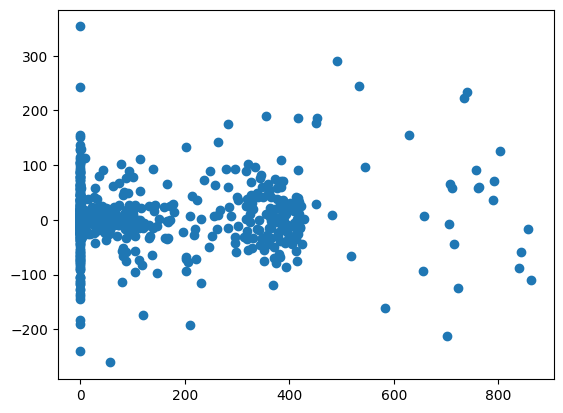

In [42]:
target = actual_target[:10, :10, :]
preds = standard_unet_preds[:10, :10 , :]

new_shape = (np.prod(target.shape[:-1]), target.shape[-1])
target_flattened = target.reshape(new_shape)
preds_flattened = preds.reshape(new_shape)

plt.scatter(target_flattened, preds_flattened)

In [24]:
#must used both preprocessed targets and preprocessed predictions
num_samples = standard_unet_preds.shape[0]
joint_r2_scores, joint_r2_scores_capped = show_r2(actual_target[:num_samples, :, :], standard_unet_preds)


joint_zonal_heating_r2 = data.zonal_bin_weight_3d(get_coeff(actual_target[:num_samples,:,:60], \
                                                                      standard_unet_preds[:,:,:60]))[0]
joint_zonal_moistening_r2 = data.zonal_bin_weight_3d(get_coeff(actual_target[:num_samples,:,60:120], \
                                                                          standard_unet_preds[:,:,60:120]))[0]

/tmp/ipykernel_2321942/1540847125.py:15: RuntimeWarning: divide by zero encountered in divide
  coeff = 1 - rss/tss


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


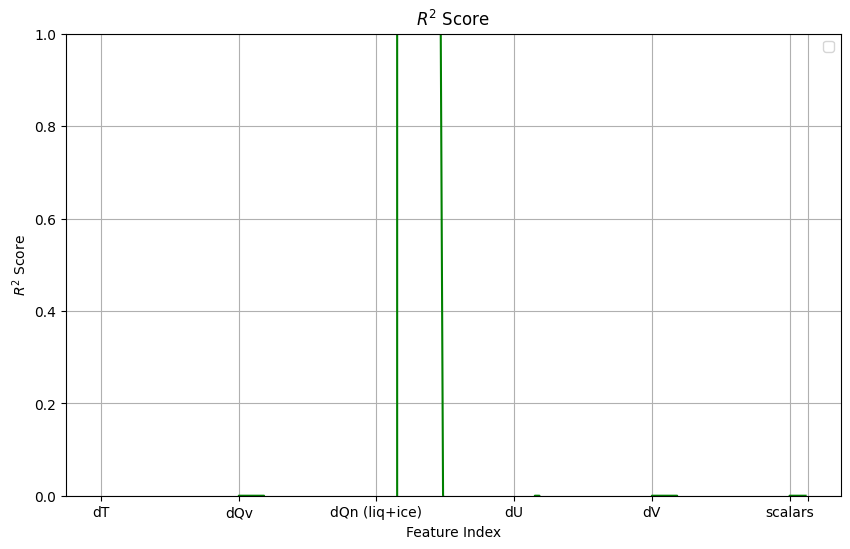

In [25]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(data.target_feature_len), joint_r2_scores, color = 'green')
    
plt.legend()
plt.xlabel('Feature Index')
plt.ylabel(r'$R^2$ Score')
plt.title(r'$R^2$ Score')

feature_indices = [0, 60, 120, 180, 240, 300, 308]
feature_labels = ['dT', 'dQv', 'dQn (liq+ice)', 'dU', 'dV', 'scalars', '']
plt.xticks(ticks=feature_indices, labels=feature_labels)
plt.ylim(0, 1)
plt.grid(True)